In [1]:
!pip install git+https://github.com/rtqichen/torchdiffeq.git

  Cloning https://github.com/rtqichen/torchdiffeq.git to /tmp/pip-req-build-ixutkq5_
  Running command git clone -q https://github.com/rtqichen/torchdiffeq.git /tmp/pip-req-build-ixutkq5_
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=25885 sha256=6af3f0b1dd78dc7e67ae1620c8896f16c9dd7c24024f8010aa0a8f2b3030d53b
  Stored in directory: /tmp/pip-ephem-wheel-cache-w0iccj63/wheels/f1/89/ce/78b4c1aabbb8dad56a2dbd776f9ffcbeca103b2ddae40d094b
Successfully built torchdiffeq


In [ ]:
import torch
import torchvision
from matplotlib import pylab as plt
import torchdiffeq

# cifar10

In [ ]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [27]:
refset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for i in range(2):
    plt.imshow(refset[i][0])
    plt.show()

# Fashion MNIST

In [ ]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,),
                                                 (0.5,)),
            ])
refset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=None)
trainset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
class MyClassifier(torch.nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(784,784),
            torch.nn.ReLU(),
            torch.nn.Linear(784,784),
            torch.nn.ReLU(),
            torch.nn.Linear(784,10),
        )
    def foward(self,x):
        return self.net(x)

In [ ]:
import copy
def copy_model(model):
    return copy.deepcopy(model)
    #C = type(model)
    #new = C()
    #new.load_state_dict(model.state_dict())
    #return new

In [ ]:
class MyResNet(torch.nn.Module):
    def __init__(self):
        super(MyResNet,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1,16,1),
            ODEBlock(ODEResBlock(16,16)),
            torch.nn.MaxPool2d(3),
            ODEBlock(ODEResBlock(16,16)),
            ODEBlock(ODEResBlock(16,16)),
            torch.nn.MaxPool2d(3),
            torch.nn.Flatten(),
            torch.nn.Linear(16*3*3,10),
        )
    def forward(self,x):
        return self.net(x)
    def refine(self):
        return copy_model(self)

class ODEBlock(torch.nn.Module):
    def __init__(self,net,t_max=1.0):
        super(ODEBlock,self).__init__()
        self.ts = torch.tensor([t_max])
        self.net = net
    def forward(self,x):
        #print(x.shape)
        h = torchdiffeq.odeint(self.net, x, self.ts).flatten(end_dim=1)
        #print(h.shape)
        return h
    def refine(self):
        return ODEBlock(self.net.refine())

class ODEResBlock(torch.nn.Module):
    def __init__(self,i_width=16, h_width=16):
        super(ODEResBlock,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(i_width,h_width,3, padding=True),
            torch.nn.ReLU(),
            torch.nn.Conv2d(h_width,i_width,3, padding=True),
            torch.nn.ReLU()
        )
    def forward(self,t,x):
        return self.net(x)
    def refine(self):
        return copy_model(self)

In [ ]:
model=MyResNet()

In [42]:
model

MyResNet(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ODEBlock(
      (net): ODEResBlock(
        (net): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (1): ReLU()
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (3): ReLU()
        )
      )
    )
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): ODEBlock(
      (net): ODEResBlock(
        (net): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (1): ReLU()
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (3): ReLU()
        )
      )
    )
    (4): ODEBlock(
      (net): ODEResBlock(
        (net): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (1): ReLU()
          (2): Con

In [41]:
model.refine()

MyResNet(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ODEBlock(
      (net): ODEResBlock(
        (net): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (1): ReLU()
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (3): ReLU()
        )
      )
    )
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): ODEBlock(
      (net): ODEResBlock(
        (net): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (1): ReLU()
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (3): ReLU()
        )
      )
    )
    (4): ODEBlock(
      (net): ODEResBlock(
        (net): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
          (1): ReLU()
          (2): Con

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
epochs=5
N_print=100
step_count = 0
losses = []

In [13]:
for e in range(epochs):
    for imgs,labels in iter(trainloader):
        #imgs = imgs.reshape(-1,784)
        #print(imgs.shape)
        optimizer.zero_grad()
        out = model(imgs)
        L = criterion(out,labels)
        L.backward()
        optimizer.step()
        losses.append(L.detach().numpy())
        if step_count % N_print == N_print-1:
            print(L.detach())
        step_count += 1

tensor(2.2326)
tensor(2.1352)
tensor(2.1051)
tensor(2.0159)
tensor(1.9792)
tensor(1.9297)
tensor(1.8648)
tensor(1.7566)
tensor(1.7827)
tensor(1.7203)
tensor(1.7577)
tensor(1.6680)
tensor(1.5806)
tensor(1.5526)
tensor(1.5224)
tensor(1.5110)
tensor(1.5707)
tensor(1.3837)
tensor(1.5392)
tensor(1.5340)
tensor(1.5839)
tensor(1.4415)
tensor(1.2898)
tensor(1.3172)
tensor(1.3571)
tensor(1.2458)
tensor(1.4743)
tensor(1.2255)
tensor(1.4212)
tensor(1.3106)
tensor(1.3026)
tensor(1.1387)
tensor(1.2018)
tensor(1.4063)
tensor(1.3077)
tensor(1.2627)
tensor(1.2693)
tensor(1.3119)
tensor(1.2533)
tensor(1.1910)
tensor(1.2549)
tensor(1.3145)
tensor(1.2239)
tensor(1.1236)
tensor(1.0710)
tensor(1.1607)


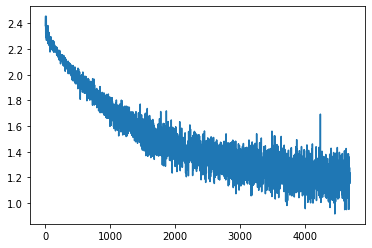

In [15]:
plt.plot(losses)

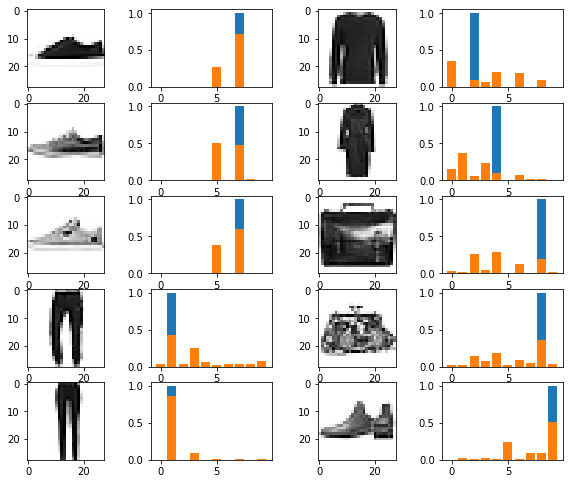

In [16]:
imgs,labels = next(iter(trainloader))
#imgsshp = imgs.reshape(-1,784)[:10,:,:,:]
res = torch.nn.Softmax(dim=-1)(model(imgs[:10,:,:,:]))
size = len(res)
plt.figure(figsize=(10,10))
for i,(pred,img,label) in enumerate(zip(res,imgs,labels)):
    plt.subplot(size//2+1,4,1+2*i)
    plt.imshow(img[0,:,:].detach().numpy(),cmap='Greys')
    plt.subplot(size//2+1,4,2+2*i)
    plt.bar(range(10),[1 if y==label else 0 for y in range(10)])
    plt.bar(range(10),pred.detach().numpy())
plt.show()

In [24]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [17]:
model.copy()

AttributeError: ignored

In [ ]:
model=MyResNet()

In [22]:
[x.shape for x in model.parameters()]

[torch.Size([16, 1, 1, 1]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([10, 144]),
 torch.Size([10])]

In [23]:
list(model.parameters())[0]

Parameter containing:
tensor([[[[-0.1556]]],


        [[[ 0.7373]]],


        [[[ 0.2549]]],


        [[[-0.1009]]],


        [[[-0.0231]]],


        [[[ 0.0458]]],


        [[[ 0.0690]]],


        [[[-0.8953]]],


        [[[ 0.8979]]],


        [[[ 0.3501]]],


        [[[-0.1884]]],


        [[[-0.5928]]],


        [[[ 0.5857]]],


        [[[-0.5611]]],


        [[[ 0.6975]]],


        [[[ 0.8713]]]], requires_grad=True)

In [ ]:
model2 =MyResNet()

In [25]:
list(model2.parameters())[0]

Parameter containing:
tensor([[[[ 0.0357]]],


        [[[-0.1638]]],


        [[[ 0.8734]]],


        [[[-0.7269]]],


        [[[-0.0800]]],


        [[[-0.1404]]],


        [[[-0.1603]]],


        [[[ 0.3851]]],


        [[[ 0.8543]]],


        [[[-0.8196]]],


        [[[-0.4913]]],


        [[[ 0.9419]]],


        [[[-0.1403]]],


        [[[ 0.8789]]],


        [[[-0.1595]]],


        [[[-0.7544]]]], requires_grad=True)

In [26]:
model2.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
C = type(model)